# Automatic Detection of Offensive Language on Social Media Using Deep Learning Model


## Setup

In [104]:
!pip install tensorflow transformers tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

### Load and Access Dataset

In [106]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# Access OLID Dataset
olid_file_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/olid-training-v1.0.tsv'
dataset = pd.read_csv(olid_file_path, delimiter='\t')


## Exploratory Data Analysis (EDA)

### Understand Datase

In [108]:
dataset.shape

(13240, 5)

In [109]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


### 2. Class Distribution Analysis


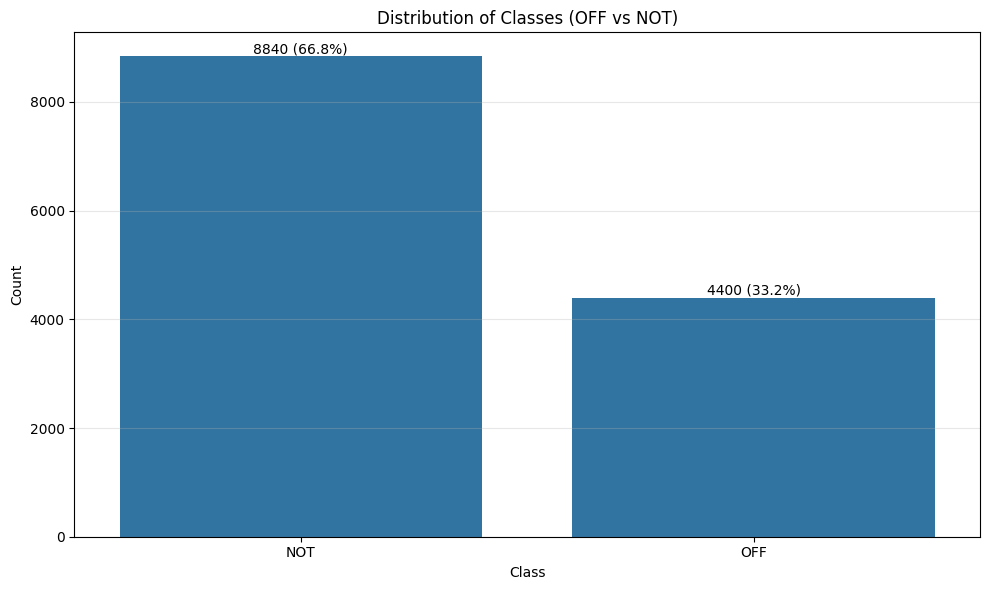

In [110]:
plt.figure(figsize=(10, 6))
class_counts = dataset['subtask_a'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes (OFF vs NOT)')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(class_counts):
    plt.text(i, count + 50, f'{count} ({count/len(dataset):.1%})', ha='center')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 3. Text Length Analysis


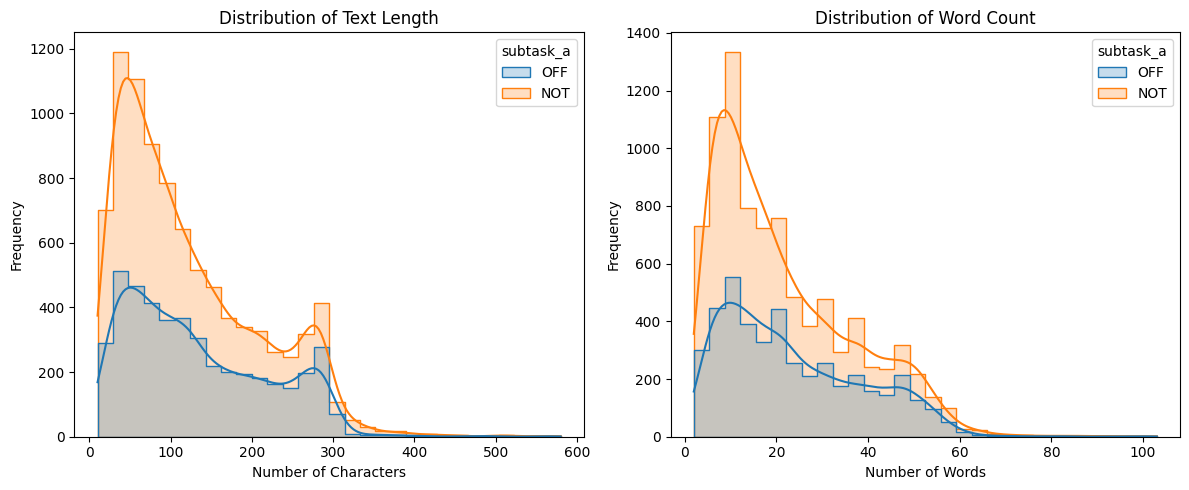

In [111]:
dataset['text_length'] = dataset['tweet'].apply(len)
dataset['word_count'] = dataset['tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=dataset, x='text_length', hue='subtask_a', bins=30, kde=True, element='step')
plt.title('Distribution of Text Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data=dataset, x='word_count', hue='subtask_a', bins=30, kde=True, element='step')
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### 4. Most Common Words Analysis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


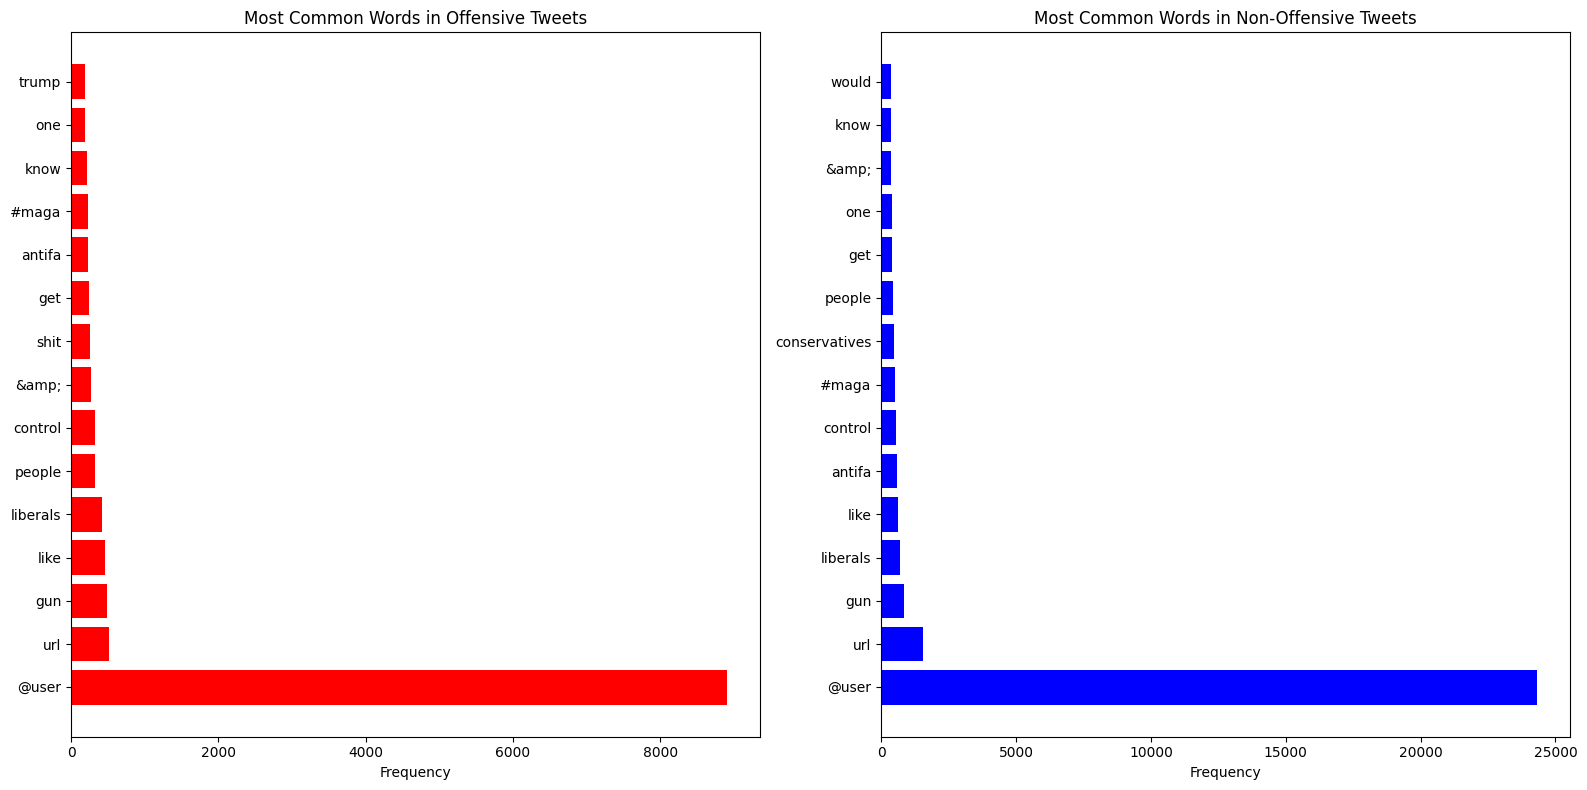

In [ ]:

stop_words = set(stopwords.words('english'))

def get_word_frequency(texts, n=20, remove_stopwords=True):
    all_words = []
    for text in texts:
        words = text.lower().split()
        if remove_stopwords:
            words = [word for word in words if word not in stop_words]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

# Get most common words for each class
off_texts = dataset[dataset['subtask_a'] == 'OFF']['tweet']
not_texts = dataset[dataset['subtask_a'] == 'NOT']['tweet']

off_words = get_word_frequency(off_texts)
not_words = get_word_frequency(not_texts)

# Plot most common words
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.barh([word[0] for word in off_words[:15]], [word[1] for word in off_words[:15]], color='red')
plt.title('Most Common Words in Offensive Tweets')
plt.xlabel('Frequency')

plt.subplot(1, 2, 2)
plt.barh([word[0] for word in not_words[:15]], [word[1] for word in not_words[:15]], color='blue')
plt.title('Most Common Words in Non-Offensive Tweets')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


### 5. Hashtag and Mention Analysis


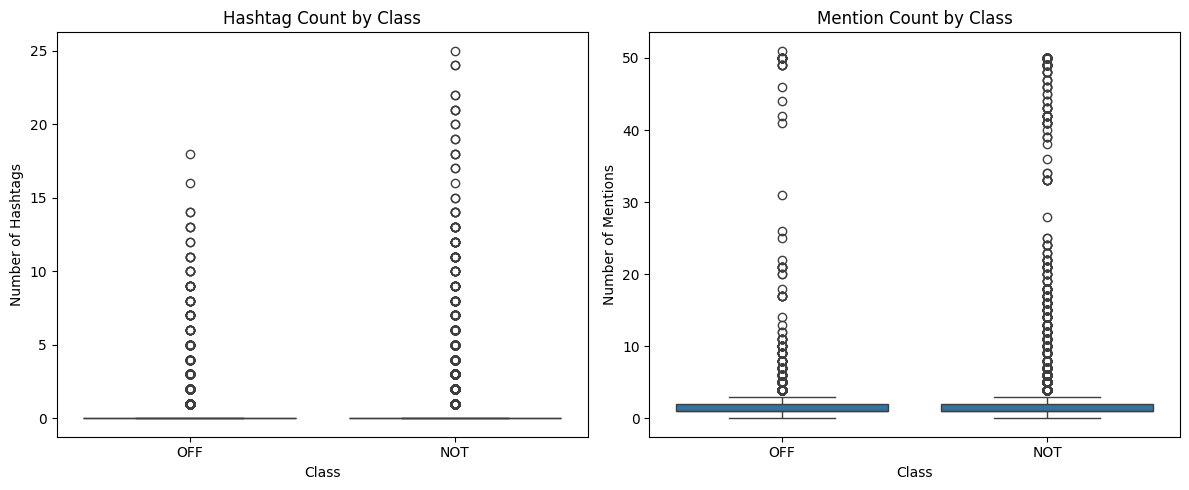

In [142]:
dataset['hashtag_count'] = dataset['tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
dataset['mention_count'] = dataset['tweet'].apply(lambda x: len(re.findall(r'@\w+', x)))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='subtask_a', y='hashtag_count', data=dataset)
plt.title('Hashtag Count by Class')
plt.xlabel('Class')
plt.ylabel('Number of Hashtags')

plt.subplot(1, 2, 2)
sns.boxplot(x='subtask_a', y='mention_count', data=dataset)
plt.title('Mention Count by Class')
plt.xlabel('Class')
plt.ylabel('Number of Mentions')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [115]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'URLs|URL', '', text)

    # Remove hashtags but keep the text
    text = re.sub(r'#(\w+)', '', text)

    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)

    # Expand contractions (simple version)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002500-\U00002BEF"
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"
            u"\u3030"
            "]+", flags=re.UNICODE
        )
    text = emoji_pattern.sub(r'', text)
    return text

# Apply preprocessing
dataset['clean_text'] = dataset['tweet'].apply(preprocess_text)

# Display a few examples
dataset[['tweet', 'clean_text', 'subtask_a']].head()

,tweet,clean_text,subtask_a
0,@USER She should ask a few native Americans wh...,she should ask a few native americans what the...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you’re drunk!!! url,OFF
2,Amazon is investigating Chinese employees who ...,amazon is investigating chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...","someone should havetaken"" this piece of shit t...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals illegals to move into re...,NOT


## Model Preperation

### Label Encoding

In [116]:
# Encode the labels
label_encoder = LabelEncoder()
dataset['encoded_label'] = label_encoder.fit_transform(dataset['subtask_a'])
print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Label mapping: {'NOT': np.int64(0), 'OFF': np.int64(1)}


### Split Dataset

In [117]:
# Split data into train and validation sets
X = dataset['clean_text']
y = dataset['encoded_label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")

Training data: 10592 samples
Validation data: 2648 samples


## Model Training

### Save trained models



In [118]:
# First, create a global dictionary to store all your trained models
trained_models = {}

# Function to store models in the global dictionary
def store_trained_model(model, model_name):
    trained_models[model_name] = model
    print(f"Model '{model_name}' has been stored successfully")
    return trained_models

In [119]:
# Initialize a global dictionary to store evaluation results
model_evaluation_results = {}

def store_model_evaluation(model_name, y_true, y_pred, train_time):
    # Calculate standard classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate macro-averaged F1 score
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Store all metrics in a dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_macro': f1_macro,
        'train_time': train_time
    }

    # Add the results to our global dictionary
    model_evaluation_results[model_name] = results

    # Print a simple confirmation
    print(f"Evaluation metrics for {model_name} have been stored successfully.")

    return results

In [120]:
# Parameters for text processing
MAX_FEATURES = 20000
MAX_LEN = 100
BERT_MAX_LEN = 128

# Prepare data for LSTM and CNN models
def prepare_sequence_data(X_train, X_val):
    # Create and fit tokenizer
    tokenizer = Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    # Pad sequences
    X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')

    return tokenizer, X_train_padded, X_val_padded

# Prepare sequence data
tokenizer, X_train_padded, X_val_padded = prepare_sequence_data(X_train, X_val)
print(f"Sequence data prepared: {X_train_padded.shape}, {X_val_padded.shape}")


Sequence data prepared: (10592, 100), (2648, 100)


### GRU

In [121]:
def build_gru_model(embedding_dim=100):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))

    # GRU layers
    model.add(Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)))
    model.add(Bidirectional(tf.keras.layers.GRU(64)))

    # Output layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

# Train GRU model (replace the BERT model)
print("Training GRU model instead of BERT...")
start_time = time.time()

# Create model
gru_model = build_gru_model(embedding_dim=100)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train on the same data as LSTM and CNN
gru_history = gru_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping]
)

# Calculate training time
gru_train_time = time.time() - start_time
print(f"GRU Training Time: {gru_train_time:.2f} seconds")

# Evaluate on validation data
gru_y_pred = (gru_model.predict(X_val_padded) > 0.5).astype(int).flatten()
print("\nGRU Model Evaluation:")
print(classification_report(y_val, gru_y_pred))

trained_model = store_trained_model(gru_model, "GRU")

Training GRU model instead of BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6402 - loss: 0.6606 - val_accuracy: 0.6677 - val_loss: 0.6334
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6730 - loss: 0.6332 - val_accuracy: 0.6677 - val_loss: 0.6230
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6755 - loss: 0.6096 - val_accuracy: 0.7073 - val_loss: 0.5704
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7687 - loss: 0.5109 - val_accuracy: 0.7292 - val_loss: 0.5470
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8335 - loss: 0.4147 - val_accuracy: 0.7538 - val_loss: 0.5511
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8633 - loss: 0.3415 - val_accuracy: 0.7515 - val_loss: 0.5930
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8875 - loss: 0.2942 - val_accuracy: 0.7519 - val_loss: 0.6124
GRU Training Time: 30.34 seconds
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

GRU Model Evaluation:
            

### Word CNN

In [122]:
def build_cnn_model(embedding_dim=100):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.2))

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Output layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

# Train CNN model
print("Training CNN model...")
start_time = time.time()

# Create model
cnn_model = build_cnn_model(embedding_dim=100)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train
cnn_history = cnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping]
)

# Calculate training time
cnn_train_time = time.time() - start_time
print(f"CNN Training Time: {cnn_train_time:.2f} seconds")

# Evaluate on validation data
cnn_y_pred = (cnn_model.predict(X_val_padded) > 0.5).astype(int).flatten()
print("\nCNN Model Evaluation:")
print(classification_report(y_val, cnn_y_pred))

trained_model = store_trained_model(cnn_model, "CNN")


Training CNN model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6506 - loss: 0.6600 - val_accuracy: 0.6677 - val_loss: 0.6381
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6684 - loss: 0.6368 - val_accuracy: 0.6677 - val_loss: 0.6331
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6639 - loss: 0.6358 - val_accuracy: 0.6677 - val_loss: 0.6287
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6701 - loss: 0.6269 - val_accuracy: 0.6677 - val_loss: 0.6215
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6758 - loss: 0.6066 - val_accuracy: 0.6983 - val_loss: 0.5896
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7437 - loss: 0.5322 - val_accuracy: 0.7466 - val_loss: 0.5159
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8357 - loss: 0.3998 - val_accuracy: 0.7594 - val_loss: 0.5131
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.3131 - val_accuracy: 0.7523 - val

### Char CNN

In [123]:
def build_char_cnn_model(max_chars=1000, char_vocab_size=128):
    model = Sequential()

    # Character embedding
    model.add(Embedding(input_dim=char_vocab_size, output_dim=50, input_length=max_chars))

    # Convolutional blocks
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))

    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # Output layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model

# For character-level processing, let's prepare the data
def prepare_char_data(X_train, X_val, max_chars=1000):
    # Create character-level tokenizer
    char_tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    char_tokenizer.fit_on_texts(X_train)

    # Convert to sequences
    X_train_char = char_tokenizer.texts_to_sequences(X_train)
    X_val_char = char_tokenizer.texts_to_sequences(X_val)

    # Pad sequences
    X_train_char_padded = pad_sequences(X_train_char, maxlen=max_chars)
    X_val_char_padded = pad_sequences(X_val_char, maxlen=max_chars)

    return char_tokenizer, X_train_char_padded, X_val_char_padded

# Prepare character-level data
print("Preparing character-level data...")
char_tokenizer, X_train_char, X_val_char = prepare_char_data(X_train, X_val, max_chars=1000)
print(f"Character data shape: {X_train_char.shape}")

# Train character-level CNN
print("Training Character-Level CNN model...")
start_time = time.time()

# Create model
char_cnn_model = build_char_cnn_model(max_chars=1000, char_vocab_size=len(char_tokenizer.word_index) + 1)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train
char_cnn_history = char_cnn_model.fit(
    X_train_char, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_char, y_val),
    callbacks=[early_stopping]
)

# Calculate training time
char_cnn_train_time = time.time() - start_time
print(f"Character CNN Training Time: {char_cnn_train_time:.2f} seconds")

# Evaluate on validation data
char_cnn_y_pred = (char_cnn_model.predict(X_val_char) > 0.5).astype(int).flatten()
print("\nCharacter CNN Model Evaluation:")
print(classification_report(y_val, char_cnn_y_pred))

trained_model = store_trained_model(char_cnn_model, "Char CNN")

Preparing character-level data...
Character data shape: (10592, 1000)
Training Character-Level CNN model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6396 - loss: 0.6651 - val_accuracy: 0.6677 - val_loss: 0.6362
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6675 - loss: 0.6394 - val_accuracy: 0.6677 - val_loss: 0.6360
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6741 - loss: 0.6344 - val_accuracy: 0.6677 - val_loss: 0.6347
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6647 - loss: 0.6397 - val_accuracy: 0.6677 - val_loss: 0.6361
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6697 - loss: 0.6361 - val_accuracy: 0.6677 - val_loss: 0.6330
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6639 - loss: 0.6361 - val_accuracy: 0.6677 - val_loss: 0.6315
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6693 - loss: 0.6312 - val_accuracy: 0.6677 - val_loss: 0.6291
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6729 - loss: 0.6247 - val_accuracy: 0.6677 - val

### LSTM

In [124]:
def build_lstm_model(embedding_dim=100):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.2))

    # Bidirectional LSTM
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

    # Output layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

# Train LSTM model
print("Training LSTM model...")
start_time = time.time()

# Create model
lstm_model = build_lstm_model(embedding_dim=100)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train
lstm_history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stopping]
)

# Calculate training time
lstm_train_time = time.time() - start_time
print(f"LSTM Training Time: {lstm_train_time:.2f} seconds")

# Evaluate on validation data
lstm_y_pred = (lstm_model.predict(X_val_padded) > 0.5).astype(int).flatten()
print("\nLSTM Model Evaluation:")
print(classification_report(y_val, lstm_y_pred))

trained_model = store_trained_model(lstm_model, "LSTM")


Training LSTM model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 79s 430ms/step - accuracy: 0.6532 - loss: 0.6577 - val_accuracy: 0.6677 - val_loss: 0.6323
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 424ms/step - accuracy: 0.6630 - loss: 0.6354 - val_accuracy: 0.6677 - val_loss: 0.6278
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 431ms/step - accuracy: 0.6636 - loss: 0.6307 - val_accuracy: 0.6677 - val_loss: 0.6184
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.6684 - loss: 0.6090 - val_accuracy: 0.7100 - val_loss: 0.5785
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 423ms/step - accuracy: 0.7567 - loss: 0.5222 - val_accuracy: 0.7432 - val_loss: 0.5357
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 424ms/step - accuracy: 0.8137 - loss: 0.4238 - val_accuracy: 0.7538 - val_loss: 0.5359
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 425ms/step - accuracy: 0.8509 - loss: 0.3598 - val_accuracy: 0.7564 - val_loss: 0.5440
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 430ms/step - accuracy: 0.8679 - loss: 0.3284 - val

### Ensemble Model

In [ ]:

print("Implementing Ensemble Model...")

# Get predictions from all models for training data
print("Generating model predictions for ensemble training...")

# For LSTM and CNN (and GRU which uses the same input format)
lstm_train_pred_proba = lstm_model.predict(X_train_padded)
cnn_train_pred_proba = cnn_model.predict(X_train_padded)
gru_train_pred_proba = gru_model.predict(X_train_padded)

# For Character CNN (uses different input format)
char_cnn_train_pred_proba = char_cnn_model.predict(X_train_char)

# Create a new feature set by combining predictions
X_ensemble_train = np.hstack([
    lstm_train_pred_proba,
    cnn_train_pred_proba,
    gru_train_pred_proba,
    char_cnn_train_pred_proba
])

# Same for validation data
lstm_val_pred_proba = lstm_model.predict(X_val_padded)
cnn_val_pred_proba = cnn_model.predict(X_val_padded)
gru_val_pred_proba = gru_model.predict(X_val_padded)
char_cnn_val_pred_proba = char_cnn_model.predict(X_val_char)

X_ensemble_val = np.hstack([
    lstm_val_pred_proba,
    cnn_val_pred_proba,
    gru_val_pred_proba,
    char_cnn_val_pred_proba
])

# Train a meta-model (Logistic Regression) on these predictions
print("Training ensemble meta-model...")
meta_model = LogisticRegression(C=1.0, class_weight='balanced')
start_time = time.time()
meta_model.fit(X_ensemble_train, y_train)
ensemble_train_time = time.time() - start_time

# Get ensemble predictions
ensemble_y_pred = meta_model.predict(X_ensemble_val)

# Evaluate ensemble model
print("\nEnsemble Model Evaluation:")
print(classification_report(y_val, ensemble_y_pred))

trained_model = store_trained_model(meta_model, "Ensemble")


Implementing Ensemble Model...
Generating model predictions for ensemble training...
331/331 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training ensemble meta-model...

Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1768
           1       0.61      0.63      0.62       880

    accuracy                           0.74      2648
   macro avg       0.71      0.72      0.71      2648
weighted avg       0.75      0.74      0.75      2648

Model 'Ensemble' has been stored successfully


## Test

### 1. Load Test Data

In [126]:
# Load test data and ground truth labels
test_dataset_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/olid_test_dataset.tsv'
test_labels_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/test_output.csv'

test_dataset = pd.read_csv(test_dataset_path, delimiter='\t')
test_labels = pd.read_csv(test_labels_path, delimiter=',', names=['id', 'subtask_a'])

print(f"Test dataset shape: {test_dataset.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Display sample of test data
print("\nTest dataset sample:")
print(test_dataset.head())
print("\nTest labels sample:")
print(test_labels.head())

Test dataset shape: (860, 2)
Test labels shape: (860, 2)

Test dataset sample:
      id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...

Test labels sample:
      id subtask_a
0  15923       OFF
1  27014       NOT
2  30530       NOT
3  13876       NOT
4  60133       OFF


### Merge Test Data with Labels

In [127]:



# Merge test data with labels
merged_test = pd.merge(test_dataset, test_labels, on='id', how='inner')
print(f"\nMerged test dataset shape: {merged_test.shape}")

# Check class distribution in test set
print("\nClass distribution in test set:")
print(merged_test['subtask_a'].value_counts())
print(merged_test['subtask_a'].value_counts(normalize=True).map('{:.2%}'.format))


Merged test dataset shape: (860, 3)

Class distribution in test set:
subtask_a
NOT    620
OFF    240
Name: count, dtype: int64
subtask_a
NOT    72.09%
OFF    27.91%
Name: proportion, dtype: object


### 3. Preprocess Test Data

In [128]:



# Apply the same preprocessing as was used for training data
merged_test['clean_text'] = merged_test['tweet'].apply(preprocess_text)

# Encode labels
test_encoded_labels = label_encoder.transform(merged_test['subtask_a'])

# Convert text to sequences for word-level models
test_word_sequences = tokenizer.texts_to_sequences(merged_test['clean_text'])
X_test_padded = pad_sequences(test_word_sequences, maxlen=MAX_LEN, padding='post')

# Convert text to sequences for character-level models
test_char_sequences = char_tokenizer.texts_to_sequences(merged_test['clean_text'])
X_test_char = pad_sequences(test_char_sequences, maxlen=1000, padding='post')

print(f"Preprocessed test data shape (word-level): {X_test_padded.shape}")
print(f"Preprocessed test data shape (char-level): {X_test_char.shape}")


Preprocessed test data shape (word-level): (860, 100)
Preprocessed test data shape (char-level): (860, 1000)


In [129]:
merged_test[['tweet','clean_text','subtask_a']].head()

,tweet,clean_text,subtask_a
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,"democrats support antifa, muslim brotherhood, ...",OFF
1,"#ConstitutionDay is revered by Conservatives, ...","is revered by conservatives, hated by progress...",NOT
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,"first, it reduces the ca url",NOT
3,#Watching #Boomer getting the news that she is...,getting the news that she is still up for paro...,NOT
4,#NoPasaran: Unity demo to oppose the far-right...,: unity demo to oppose the far-right in – — en...,OFF



### Test Dataset Evaluation for All Models


In [130]:
def evaluate_on_test(model_name, model, X_test, y_test):
    print(f"\nEvaluating {model_name} on test data...")

    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

# Evaluate all models
test_results = {}

### LSTM Test

In [131]:
# LSTM
test_results['LSTM'] = evaluate_on_test('LSTM', trained_models['LSTM'], X_test_padded, test_encoded_labels)


Evaluating LSTM on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Accuracy: 0.7465
Precision: 0.5821
Recall: 0.3250
F1 Score: 0.4171


### Word CNN Test

In [132]:
test_results['CNN'] = evaluate_on_test('CNN', trained_models['CNN'], X_test_padded, test_encoded_labels)



Evaluating CNN on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.7895
Precision: 0.6667
Recall: 0.4917
F1 Score: 0.5659


### GRU Test

In [133]:
test_results['GRU'] = evaluate_on_test('GRU', trained_models['GRU'], X_test_padded, test_encoded_labels)



Evaluating GRU on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.7221
Precision: 0.5025
Recall: 0.4208
F1 Score: 0.4580


### Character CNN Test

In [134]:
test_results['Char CNN'] = evaluate_on_test('Char CNN', trained_models['Char CNN'], X_test_char, test_encoded_labels)


Evaluating Char CNN on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.7384
Precision: 0.6230
Recall: 0.1583
F1 Score: 0.2525


### Ensemble Model Test

In [135]:
lstm_test_pred = trained_models['LSTM'].predict(X_test_padded)
cnn_test_pred = trained_models['CNN'].predict(X_test_padded)
gru_test_pred = trained_models['GRU'].predict(X_test_padded)
char_cnn_test_pred = trained_models['Char CNN'].predict(X_test_char)
X_ensemble_test = np.hstack([lstm_test_pred, cnn_test_pred, gru_test_pred, char_cnn_test_pred])
test_results['Ensemble'] = evaluate_on_test('Ensemble', trained_models['Ensemble'], X_ensemble_test, test_encoded_labels)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Evaluating Ensemble on test data...
Accuracy: 0.7721
Precision: 0.5991
Recall: 0.5542
F1 Score: 0.5758


### Result Comparision

In [136]:
# Create comparison DataFrame
comparison_results = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [test_results[m]['accuracy'] for m in test_results],
    'Precision': [test_results[m]['precision'] for m in test_results],
    'Recall': [test_results[m]['recall'] for m in test_results],
    'F1 Score': [test_results[m]['f1'] for m in test_results]
})

comparison_results

,Model,Accuracy,Precision,Recall,F1 Score
0,LSTM,0.746512,0.582090,0.325000,0.417112
1,CNN,0.789535,0.666667,0.491667,0.565947
2,GRU,0.722093,0.502488,0.420833,0.458050
3,Char CNN,0.738372,0.622951,0.158333,0.252492
4,Ensemble,0.772093,0.599099,0.554167,0.575758


## Conclusion

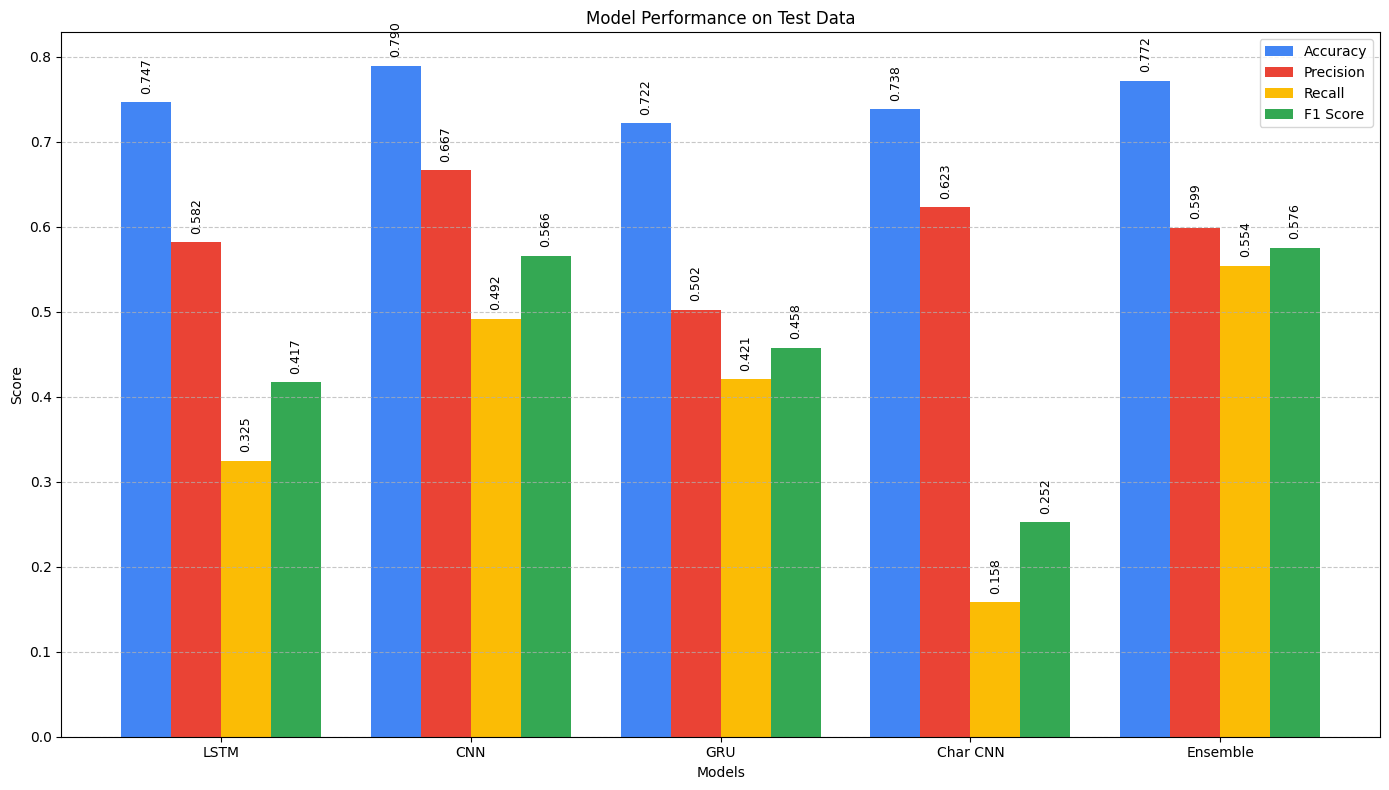

In [137]:
plt.figure(figsize=(14, 8))

x = np.arange(len(test_results))
width = 0.2

plt.bar(x - width*1.5, [test_results[m]['accuracy'] for m in test_results], width, label='Accuracy', color='#4285F4')
plt.bar(x - width/2, [test_results[m]['precision'] for m in test_results], width, label='Precision', color='#EA4335')
plt.bar(x + width/2, [test_results[m]['recall'] for m in test_results], width, label='Recall', color='#FBBC05')
plt.bar(x + width*1.5, [test_results[m]['f1'] for m in test_results], width, label='F1 Score', color='#34A853')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance on Test Data')
plt.xticks(x, list(test_results.keys()))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, model in enumerate(test_results):
    metrics = [
        test_results[model]['accuracy'],
        test_results[model]['precision'],
        test_results[model]['recall'],
        test_results[model]['f1']
    ]

    for j, metric in enumerate(metrics):
        plt.text(i + (j-1.5)*width, metric + 0.01, f'{metric:.3f}',
                 ha='center', va='bottom', rotation=90, fontsize=9)

plt.tight_layout()
plt.show()


### Confusion Matrices

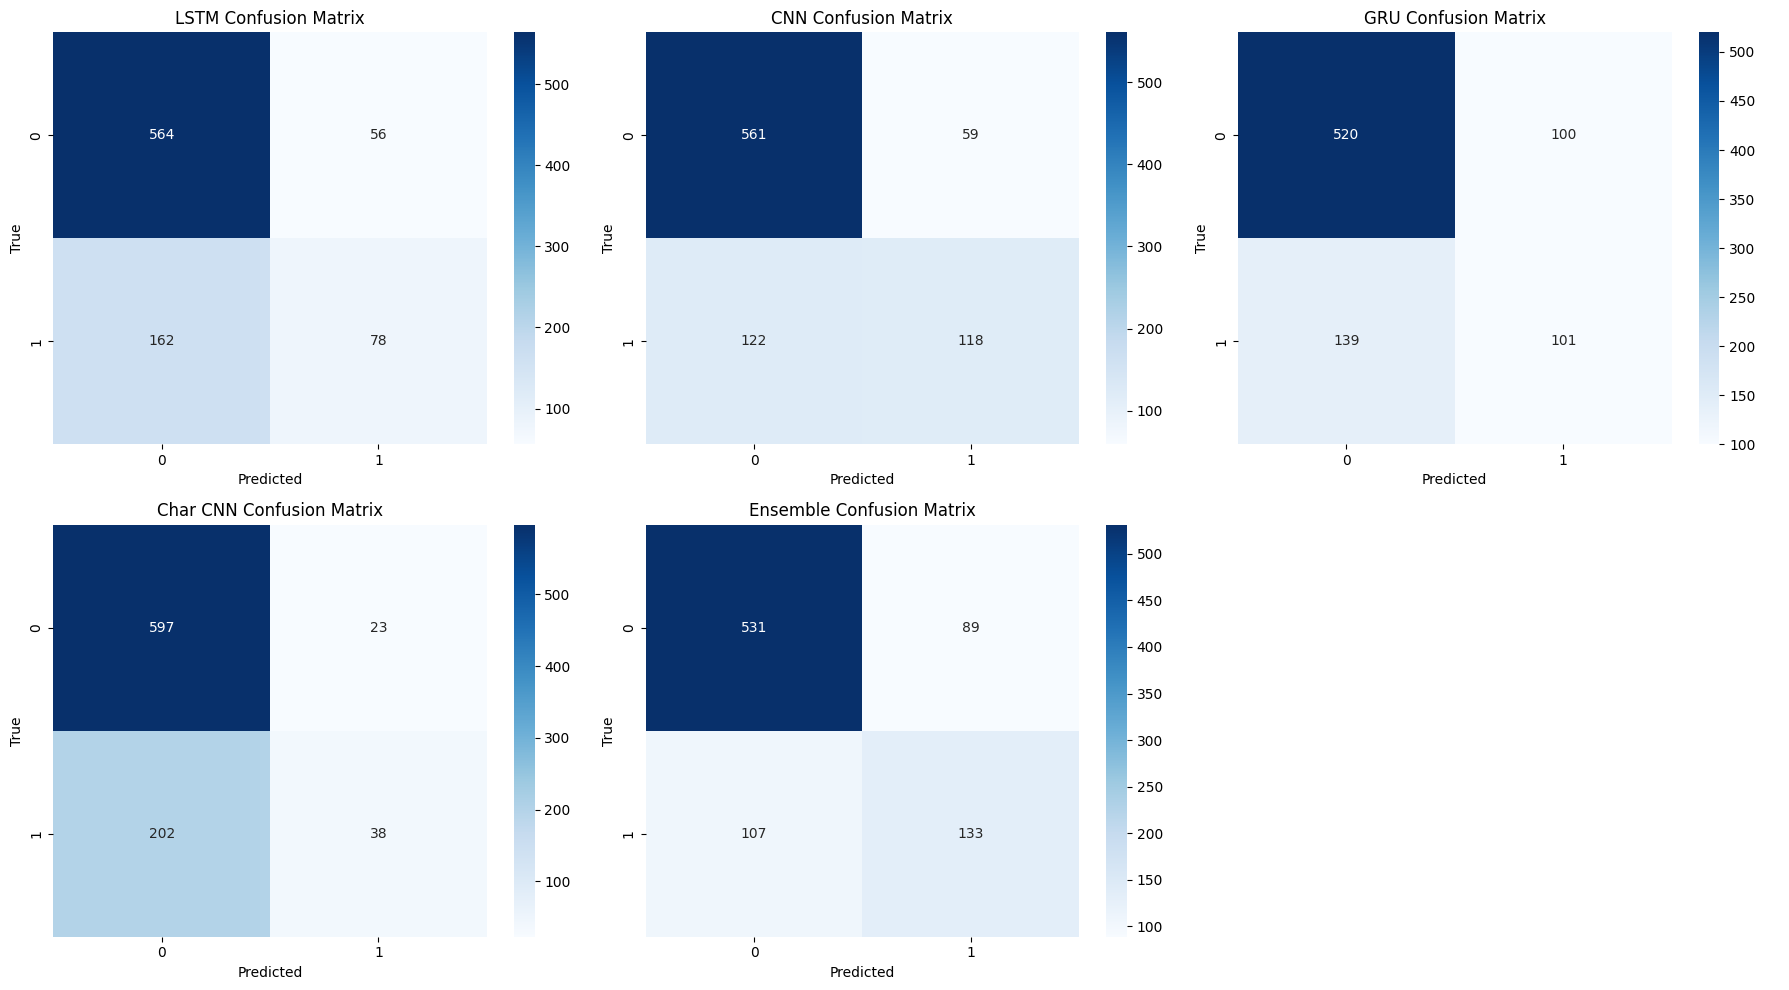

In [138]:

# Visualize confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, model_name in enumerate(test_results):
    if i < len(axes):
        cm = test_results[model_name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"{model_name} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

# Hide any unused subplots
for j in range(len(test_results), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 1. ROC Curve Analysis


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


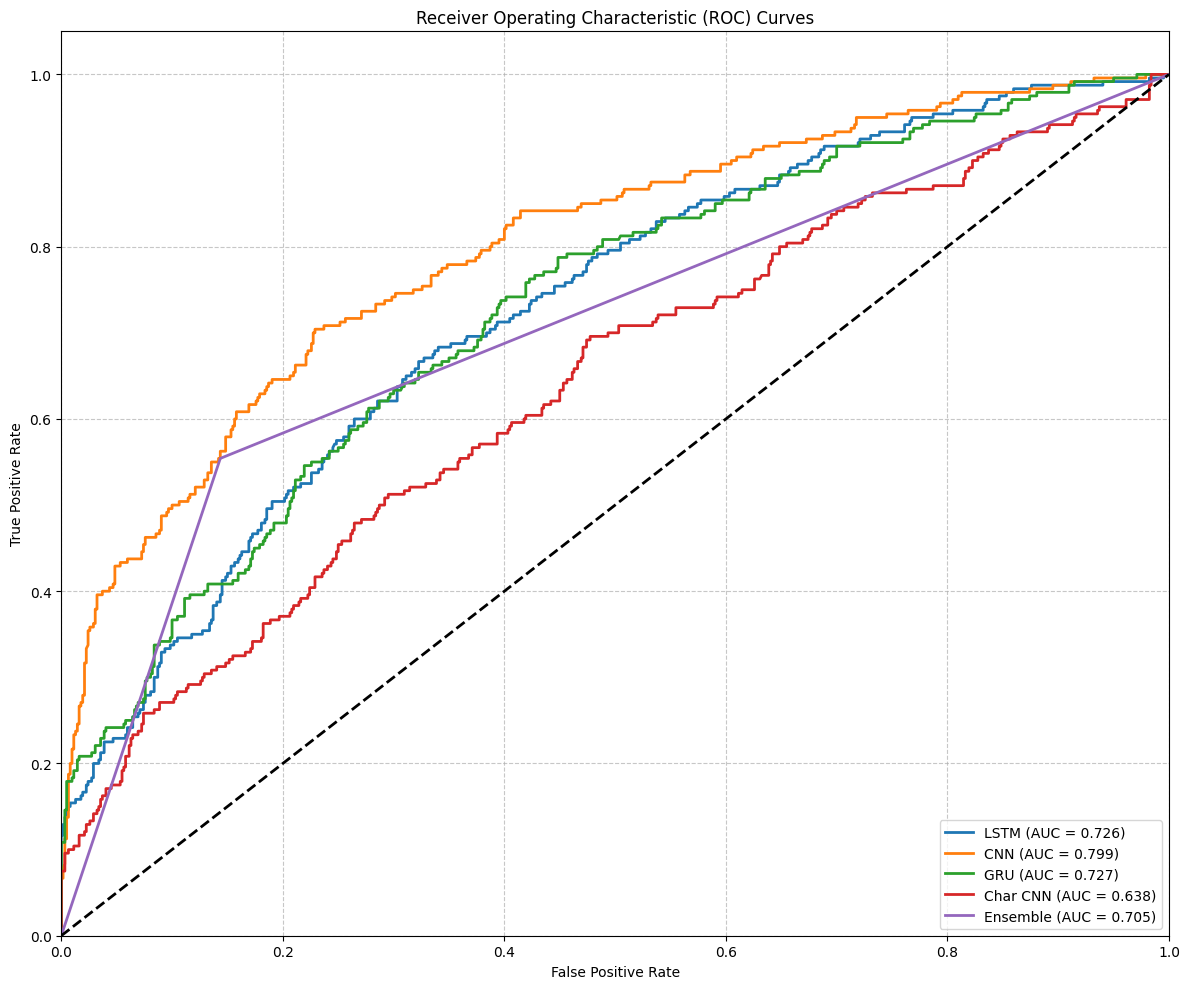

In [139]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for all models
plt.figure(figsize=(12, 10))

# Plot for each model
for model_name in test_results.keys():
    # Get the appropriate test data and model
    if model_name == 'Char CNN':
        X_test = X_test_char
        model = trained_models['Char CNN']
    elif model_name == 'Ensemble':
        # For ensemble, we need to create the ensemble predictions
        lstm_pred = trained_models['LSTM'].predict(X_test_padded)
        cnn_pred = trained_models['CNN'].predict(X_test_padded)
        gru_pred = trained_models['GRU'].predict(X_test_padded)
        char_cnn_pred = trained_models['Char CNN'].predict(X_test_char)
        X_test = np.hstack([lstm_pred, cnn_pred, gru_pred, char_cnn_pred])
        model = trained_models['Ensemble']
    else:
        X_test = X_test_padded
        model = trained_models[model_name]

    # Get prediction probabilities
    y_score = model.predict(X_test).flatten()

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(test_encoded_labels, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Store AUC in results
    test_results[model_name]['roc_auc'] = roc_auc

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [140]:
# ====================================================================
# 4. Model Recommendation
# ====================================================================

# Rank models by different metrics
best_by_accuracy = comparison_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_by_precision = comparison_results.sort_values('Precision', ascending=False).iloc[0]['Model']
best_by_recall = comparison_results.sort_values('Recall', ascending=False).iloc[0]['Model']
best_by_f1 = comparison_results.sort_values('F1 Score', ascending=False).iloc[0]['Model']

print("\n=== Model Recommendation ===")
print(f"Best model by Accuracy: {best_by_accuracy}")
print(f"Best model by Precision: {best_by_precision}")
print(f"Best model by Recall: {best_by_recall}")
print(f"Best model by F1 Score: {best_by_f1}")

# Count model wins
win_counts = {model: 0 for model in test_results.keys()}
win_counts[best_by_accuracy] += 1
win_counts[best_by_precision] += 1
win_counts[best_by_recall] += 1
win_counts[best_by_f1] += 1
# Overall best model
overall_best = max(win_counts.items(), key=lambda x: x[1])
print("\nFinal recommendation:")
print(f"For balanced performance across all metrics: Use {overall_best[0]}")
print(f"For highest precision (reducing false positives): Use {best_by_precision}")
print(f"For highest recall (catching most offensive content): Use {best_by_recall}")
print(f"For best trade-off between precision and recall: Use {best_by_f1}")


=== Model Recommendation ===
Best model by Accuracy: CNN
Best model by Precision: CNN
Best model by Recall: Ensemble
Best model by F1 Score: Ensemble

Final recommendation:
For balanced performance across all metrics: Use CNN
For highest precision (reducing false positives): Use CNN
For highest recall (catching most offensive content): Use Ensemble
For best trade-off between precision and recall: Use Ensemble
